In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import files
import os

files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!pip install kaggle

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/ham10000_data --unzip

print("Dataset downloaded and extracted successfully.")


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:31<00:00, 226MB/s]
100% 5.20G/5.20G [00:31<00:00, 177MB/s]
Dataset downloaded and extracted successfully.


In [5]:
# Loads dataset, creates binary labels and image paths, splits into train/test sets, and converts labels to integers.

main_df = pd.read_csv("/content/ham10000_data/HAM10000_metadata.csv")
main_df['binary_label'] = main_df['dx'].apply(lambda x: 1 if x == 'mel' else 0)
main_df['path'] = main_df['image_id'].apply(lambda x: f"/content/ham10000_data/HAM10000_images/{x}.jpg")
print("Dataset loaded and paths updated.")
train_df, test_df = train_test_split(main_df, test_size=0.2, stratify=main_df['binary_label'], random_state=42)

print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")
train_df['binary_label'] = train_df['binary_label'].astype(int)

Dataset loaded and paths updated.
Training samples: 8012, Testing samples: 2003


In [6]:
# Separates melanoma and non-melanoma cases, checks for empty classes, and balances the training data by upsampling melanoma cases.

melanoma = train_df[train_df['binary_label'] == 1]
non_melanoma = train_df[train_df['binary_label'] == 0]

if len(melanoma) == 0 or len(non_melanoma) == 0:
    print("Error: One of the classes is empty. Check the label distribution in the training data.")
else:
    melanoma_upsampled = resample(
        melanoma,
        replace=True,
        n_samples=len(non_melanoma),
        random_state=42
    )
    train_df_balanced = pd.concat([non_melanoma, melanoma_upsampled])

    print("Training data after balancing:")
    print(train_df_balanced['binary_label'].value_counts())


Training data after balancing:
binary_label
0    7122
1    7122
Name: count, dtype: int64


In [7]:
# Defines a function to locate the image file path based on `image_id` and applies it to add paths for images in both training and testing datasets.

def get_image_path(image_id):
    part_1_path = f"/content/ham10000_data/ham10000_images_part_1/{image_id}.jpg"
    part_2_path = f"/content/ham10000_data/ham10000_images_part_2/{image_id}.jpg"

    if os.path.exists(part_1_path):
        return part_1_path
    elif os.path.exists(part_2_path):
        return part_2_path
    else:
        return None

train_df['path'] = train_df['image_id'].apply(get_image_path)
test_df['path'] = test_df['image_id'].apply(get_image_path)


In [8]:
# Checks if image paths in training and testing sets exist and prints the count of valid image paths for each set.

train_valid_paths = train_df['path'].apply(lambda x: os.path.exists(x))
test_valid_paths = test_df['path'].apply(lambda x: os.path.exists(x))

print(f"Number of valid image paths in training set: {train_valid_paths.sum()}/{len(train_df)}")
print(f"Number of valid image paths in testing set: {test_valid_paths.sum()}/{len(test_df)}")


Number of valid image paths in training set: 8012/8012
Number of valid image paths in testing set: 2003/2003


In [9]:
# Converts labels to strings, augments/rescales images, and creates data generators for training/testing.

train_df['binary_label'] = train_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="path",
    y_col="binary_label",
    class_mode="binary",
    target_size=(224, 224),
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="path",
    y_col="binary_label",
    class_mode="binary",
    target_size=(224, 224),
    batch_size=32
)

Found 8012 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.


In [10]:
# Retrieves and prints the shape of one batch of images from the training generator.

batch_x, batch_y = next(train_generator)
print("Shape of a batch of images:", batch_x.shape)

Shape of a batch of images: (32, 224, 224, 3)


In [11]:
# Defines focal loss, builds and compiles a fine-tuned MobileNetV2 model, and sets up learning rate scheduling and early stopping.

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred)
        fl = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

base_model = MobileNetV2(input_tensor=input_layer, include_top=False, weights="imagenet")

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy", "Precision", "Recall"]
)

model.summary()

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [12]:
# Trains the model for 30 epochs with validation and callbacks.

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/30
251/251 [==============================] - 243s 918ms/step - loss: 0.0723 - accuracy: 0.7959 - precision: 0.1359 - recall: 0.1562 - val_loss: 0.1525 - val_accuracy: 0.5701 - val_precision: 0.1416 - val_recall: 0.5650 - lr: 1.0000e-05
Epoch 2/30
251/251 [==============================] - 218s 867ms/step - loss: 0.0356 - accuracy: 0.8864 - precision: 0.4333 - recall: 0.0730 - val_loss: 0.0495 - val_accuracy: 0.8652 - val_precision: 0.2418 - val_recall: 0.0987 - lr: 1.0000e-05
Epoch 3/30
251/251 [==============================] - 215s 854ms/step - loss: 0.0336 - accuracy: 0.8872 - precision: 0.4573 - recall: 0.0843 - val_loss: 0.0457 - val_accuracy: 0.8902 - val_precision: 0.7143 - val_recall: 0.0224 - lr: 1.0000e-05
Epoch 4/30
251/251 [==============================] - 218s 865ms/step - loss: 0.0317 - accuracy: 0.8915 - precision: 0.5614 - recall: 0.1079 - val_loss: 0.0516 - val_accuracy: 0.8892 - val_precision: 1.0000 - val_recall: 0.0045 - lr: 1.0000e-05
Epoch 5/30
251/251 [

In [13]:
# Evaluates the model on the test set and prints loss, accuracy, precision, and recall.

results = model.evaluate(test_generator)

loss, accuracy, precision, recall = results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


63/63 [==============================] - 16s 248ms/step - loss: 0.0457 - accuracy: 0.8902 - precision: 0.7143 - recall: 0.0224
Test Loss: 0.04566571116447449
Test Accuracy: 0.8901647329330444
Test Precision: 0.7142857313156128
Test Recall: 0.022421523928642273


In [14]:
# Resets the test generator, makes predictions with a 0.2 threshold, and prints the classification report and confusion matrix.

test_generator.reset()
predictions = model.predict(test_generator)

threshold = 0.2
predicted_classes = (predictions > threshold).astype("int32")

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report with threshold", threshold, ":\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_classes, predicted_classes))


63/63 [==============================] - 17s 251ms/step
Classification Report with threshold 0.2 :

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1780
           1       0.13      0.27      0.17       223

    accuracy                           0.71      2003
   macro avg       0.51      0.52      0.50      2003
weighted avg       0.81      0.71      0.75      2003

Confusion Matrix:

[[1357  423]
 [ 162   61]]


1/1 [==============================] - 1s 718ms/step


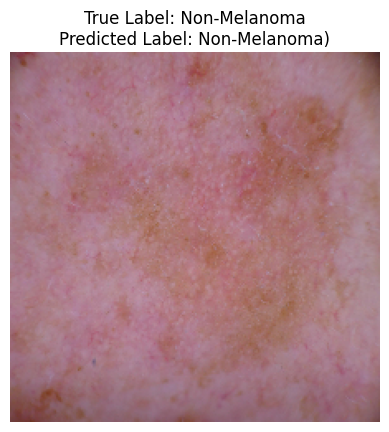

In [15]:
# Selects a random test image, loads and preprocesses it, predicts its label, and displays the image with its true and predicted labels.

random_index = random.randint(0, len(test_df) - 1)
image_path = test_df.iloc[random_index]['path']
true_label = int(test_df.iloc[random_index]['binary_label'])

image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)


predicted_prob = model.predict(image_array)[0][0]
predicted_label = 1 if predicted_prob > 0.5 else 0


plt.imshow(image)
plt.axis("off")
plt.title(f"True Label: {'Melanoma' if true_label == 1 else 'Non-Melanoma'}\n"
          f"Predicted Label: {'Melanoma' if predicted_label == 1 else 'Non-Melanoma'})")
plt.show()